# Install

In [1]:
%pip install tensorflow tf2onnx matplotlib numpy opencv-python scipy

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.3.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached scipy-1.16.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using

In [3]:
%pip install --upgrade --force-reinstall numpy h5py tensorflow

  Using cached numpy-2.3.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached h5py-3.15.0-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached six

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.


# import and constant

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import string
import os
import shutil

In [2]:
dataset_dir = './dataset'
model_name = 'sign_classifier'

# Dataset

In [6]:
!curl -L -o ./alfabet-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/achmadnoer/alfabet-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  114M    0 83232    0     0  54378      0  0:36:51  0:00:01  0:36:50 54378
  8  114M    8 10.0M    0     0  4148k      0  0:00:28  0:00:02  0:00:26 10.5M
 18  114M   18 21.2M    0     0  6273k      0  0:00:18  0:00:03  0:00:15 10.9M
 28  114M   28 32.5M    0     0  7453k      0  0:00:15  0:00:04  0:00:11 11.0M
 38  114M   38 43.8M    0     0  8198k      0  0:00:14  0:00:05  0:00:09 11.0M
 48  114M   48 55.1M    0     0  8716k      0  0:00:13  0:00:06  0:00:07 11.1M
 56  114M   56 65.1M    0     0  8920k      0  0:00:13  0:00:07  0:00:06 11.0M
 66  114M   66 76.4M    0     0  9230k      0  0:0

In [18]:
import zipfile
import os
import platform

zip_path = "./alfabet-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./alfabet-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [19]:
import os
import shutil

src_dir = "Citra BISINDO"
dst_dir = "./dataset"

if not os.path.exists(src_dir):
    raise FileNotFoundError(f"❌ Folder sumber tidak ditemukan: {src_dir}")

os.makedirs(dst_dir, exist_ok=True)

print(f"📂 Memindahkan '{src_dir}' ke '{dst_dir}' ...")
shutil.move(src_dir, dst_dir)
print(f"✅ Berhasil dipindahkan ke {dst_dir}")


📂 Memindahkan 'Citra BISINDO' ke './dataset' ...
✅ Berhasil dipindahkan ke ./dataset


In [1]:
!curl -L -o ./indonesian-sign-language-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/agungmrf/indonesian-sign-language-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1396M    0  110k    0     0  70686      0  5:45:23  0:00:01  5:45:22  111k
  0 1396M    0 2528k    0     0   976k      0  0:24:25  0:00:02  0:24:23 1277k
  0 1396M    0 7005k    0     0  1950k      0  0:12:13  0:00:03  0:12:10 2350k
  0 1396M    0 11.4M    0     0  2551k      0  0:09:20  0:00:04  0:09:16 2942k
  1 1396M    1 16.0M    0     0  2945k      0  0:08:05  0:00:05  0:08:00 3306k
  1 1396M    1 20.4M    0     0  3179k      0  0:07:29  0:00:06  0:07:23 4178k
  1 1396M    1 23.4M    0     0  3167k      0  0:07:31  0:00:07  0:07:24 4303k
  1 1396M    1 27.1M    0     0  3238k      0  0:0

In [2]:
def merge_dataset(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    Example: src_folder/cat -> dataset/cat
             src_folder/dog -> dataset/dog
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all label folders in the source
    for label in os.listdir(src_folder):
        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Skip if not a folder
        if not os.path.isdir(label_path_src):
            continue

        # Create label folder in destination if needed
        os.makedirs(label_path_dest, exist_ok=True)

        # Move all files from src → dest
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Avoid overwriting files with same name
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_2{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
import zipfile
import os
import platform

zip_path = "./indonesian-sign-language-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./indonesian-sign-language-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [8]:
merge_dataset('./bisindo/images/train')

✅ Merged './bisindo/images/train' into './dataset' successfully!


In [9]:
merge_dataset('./bisindo/images/val')

✅ Merged './bisindo/images/val' into './dataset' successfully!


In [10]:
import shutil
import os

folder_path = "./bisindo"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./bisindo
✅ Folder berhasil dihapus.


In [11]:
!curl -L -o ./bisindo-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/yunitayupratiwi/bisindo-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [12]:
import zipfile
import os
import platform

zip_path = "./bisindo-dataset.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-dataset.zip ...
✅ Dataset berhasil diekstrak ke ./


In [13]:
def construct_dataset(src_folder):
    """
    Move files from src_folder into dataset, based on the first letter of the filename.
    Example: src_folder/A.66ae97e2-c1e4-11eb-83d3-0008ca6b6d30.jpg -> dataset/A
             src_folder/B.002d8fdf-c1e3-11eb-952a-0008ca6b6d30.jpg -> dataset/B
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all file folders in the source
    for filename in os.listdir(src_folder):
        src_file = os.path.join(src_folder, filename)

        # Skip if a folder
        if os.path.isdir(src_file):
            continue
        
        # Skip if not a jpg
        if not src_file.lower().endswith('.jpg'):
            continue
        
        label = filename[0].upper()  # First character as label
        dest = os.path.join(dataset_dir, label)
        # Create label folder in destination if needed
        os.makedirs(dest, exist_ok=True)

        dst_file = os.path.join(dest, filename)

        # Avoid overwriting files with same name
        if os.path.exists(dst_file):
            base, ext = os.path.splitext(filename)
            dst_file = os.path.join(dest, f"{base}_3{ext}")

        shutil.move(src_file, dst_file)

    print(f"successfully!")

In [14]:
construct_dataset("./BISINDO - Dataset/test")

successfully!


In [15]:
construct_dataset("./BISINDO - Dataset/train")

successfully!


In [16]:
import shutil
import os

folder_path = "./BISINDO - Dataset"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./BISINDO - Dataset
✅ Folder berhasil dihapus.


In [ ]:
!curl -L -o ./sign-language-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/bonarsitorus/sign-language-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [ ]:
def merge_dataset_4(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure,
    except folders with '_npy' in their name.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):
        # Lewati folder yang mengandung '_npy'
        if "_npy" in label:
            continue

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_4{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
merge_dataset_4('./data_tambahan')

In [ ]:
import shutil
import os

folder_path = "./data_tambahan"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

In [ ]:
!curl -L -o ./indonesian-hand-sign-language-bisindo-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/kelsha/indonesian-hand-sign-language-bisindo-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [ ]:
def merge_dataset_5(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_5{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
merge_dataset_5('./dataset_bsindo/train/images')

In [ ]:
merge_dataset_5('./dataset_bsindo/val/images')

In [ ]:
import shutil
import os

folder_path = "./dataset_bsindo"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

In [ ]:
!curl -L -o ./bisindo-final.zip\
  https://www.kaggle.com/api/v1/datasets/download/skripsiairlangga/bisindo-final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [ ]:
import zipfile
import os
import platform

zip_path = "./indonesian-hand-sign-language-bisindo-dataset.zip"
extract_dir = "./bisindo_final"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

# Membuat folder extract_dir jika belum ada
os.makedirs(extract_dir, exist_ok=True)

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


In [ ]:
def merge_dataset_6(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_6{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
merge_dataset_6('./bisindo_final')

In [ ]:
import shutil
import os

folder_path = "./bisindo_final"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

# Train

In [ ]:
# === Data generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 23267 images belonging to 26 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5805 images belonging to 26 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# === Train ===
history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size),
    epochs=100,
    callbacks=[early_stopping]
)

c:\Users\WINDOWS 10\anaconda3\envs\aienv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7258 - loss: 1.0113

c:\Users\WINDOWS 10\anaconda3\envs\aienv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


727/727 ━━━━━━━━━━━━━━━━━━━━ 604s 827ms/step - accuracy: 0.8124 - loss: 0.6622 - val_accuracy: 0.2814 - val_loss: 2.9712
Epoch 2/100
  1/727 ━━━━━━━━━━━━━━━━━━━━ 3:10 263ms/step - accuracy: 0.9062 - loss: 0.3250

c:\Users\WINDOWS 10\anaconda3\envs\aienv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


727/727 ━━━━━━━━━━━━━━━━━━━━ 108s 148ms/step - accuracy: 0.9062 - loss: 0.3250 - val_accuracy: 0.2831 - val_loss: 2.9641
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 431s 593ms/step - accuracy: 0.8996 - loss: 0.3285 - val_accuracy: 0.2776 - val_loss: 3.7643
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 107s 148ms/step - accuracy: 0.9062 - loss: 0.1542 - val_accuracy: 0.2742 - val_loss: 3.7363
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 432s 594ms/step - accuracy: 0.9232 - loss: 0.2453 - val_accuracy: 0.2640 - val_loss: 3.9721
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 107s 147ms/step - accuracy: 0.9688 - loss: 0.1299 - val_accuracy: 0.2640 - val_loss: 3.9604
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 425s 585ms/step - accuracy: 0.9362 - loss: 0.2004 - val_accuracy: 0.3118 - val_loss: 3.4334
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 103s 142ms/step - accuracy: 0.9375 - loss: 0.1028 - val_accuracy: 0.3044 - val_loss: 3.4701
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 418s 575ms/step - accuracy: 0.9433 - los

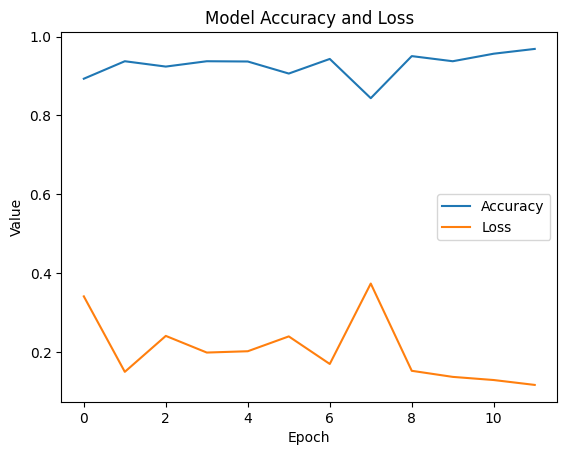

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'])
plt.show()

# save model

In [24]:
model.save(f"{model_name}.keras")

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open(f"{model_name}.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\WINDOW~1\AppData\Local\Temp\tmprttpt2my\assets


INFO:tensorflow:Assets written to: C:\Users\WINDOW~1\AppData\Local\Temp\tmprttpt2my\assets


Saved artifact at 'C:\Users\WINDOW~1\AppData\Local\Temp\tmprttpt2my'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2170113002960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113003536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113005264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113005072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113003920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113005456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113006032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113005648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2170113003728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

# test model

In [5]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=f"{model_name}.tflite")
interpreter.allocate_tensors()

/opt/anaconda3/envs/ai-rhn/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
# Get input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape'][1:3]  # (224, 224)

In [7]:
# List of labels A-Z
labels = list(string.ascii_uppercase)

In [8]:
from IPython.display import display, clear_output
import cv2
import numpy as np
from PIL import Image
import time


cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img = cv2.resize(frame, (224, 224))
        input_data = np.expand_dims(img.astype(np.float32) / 255.0, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output)
        letter = labels[pred] if pred < len(labels) else "?"

        cv2.putText(frame, f"Pred: {letter}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        clear_output(wait=True)
        display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

finally:
    cap.release()
    time.sleep(0.5)
    del cap
    cv2.VideoCapture(0).release()
    cv2.destroyAllWindows()
    print("Camera released.")


Camera released.


KeyboardInterrupt: 